In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
data = pd.read_csv('extracted_data.csv')
data.head(10)
data['image'] = data.apply(lambda row: str(row['id_x']) + ".jpg", axis=1)

data = data.reset_index(drop=True)
data.head(10)

,Unnamed: 0,id_x,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Rainy,2011.0,Casual,...,1.759050,5.455353,2.264873,22.648228,0.318423,0.000000,9.307659,2.485376,2.589488,18.344494
1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Sunny,2012.0,Casual,...,2.459627,8.469259,5.472922,8.990246,3.187692,0.256664,7.267747,0.000000,6.571844,17.669731
2,3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Rainy,2011.0,Casual,...,29.042683,1.647553,0.176533,0.000000,6.040608,1.806891,10.376255,0.000000,16.299793,16.499523
3,4,53759,Men,Apparel,Topwear,Tshirts,Grey,Sunny,2012.0,Casual,...,2.014328,6.502707,3.596585,19.685736,6.044678,0.000000,8.757938,2.212007,4.258549,17.862133
4,5,1855,Men,Apparel,Topwear,Tshirts,Grey,Sunny,2011.0,Casual,...,3.938444,2.859155,2.247991,17.592136,0.253539,3.850347,6.854544,1.996476,8.032393,16.529812
5,6,30805,Men,Apparel,Topwear,Shirts,Green,Sunny,2012.0,Ethnic,...,8.074385,2.841673,0.000000,17.579628,0.000000,0.815755,7.742965,6.793867,3.896430,6.004035
6,7,26960,Women,Apparel,Topwear,Shirts,Purple,Sunny,2012.0,Casual,...,4.237893,4.720810,4.666629,14.129210,5.321120,0.000000,12.770954,4.054196,2.739104,4.012745
7,10,9204,Men,Footwear,Shoes,Casual Shoes,Black,Sunny,2011.0,Casual,...,0.498734,5.976805,2.694166,0.000000,2.715871,7.275645,0.919224,0.650789,6.954916,1.359664
8,12,18653,Men,Footwear,Flip Flops,Flip Flops,Black,Rainy,2011.0,Casual,...,0.000000,8.277502,0.000000,0.000000,11.000808,6.638534,13.038217,3.999138,2.902048,7.825822
9,14,46885,Men,Footwear,Flip Flops,Flip Flops,Navy Blue,Rainy,2012.0,Casual,...,14.232155,3.802810,1.326976,4.938066,3.582548,0.284768,1.239550,2.517563,10.421501,0.000000


In [3]:
print(data['subCategory'].unique())

['Topwear' 'Bottomwear' 'Shoes' 'Flip Flops' 'Sandal' 'Dress']


In [4]:
# Define a mapping for the transformations
category_mapping = {
    'Shoes': 'Footwear',
    'Flip Flops': 'Footwear',
    'Sandal': 'Footwear',
    'Topwear': 'TopWear',
    'Dress': 'TopWear',
    'Bottomwear': 'Bottomwear'  # No change
}

# Apply the mapping to the 'subCategory' column
data['subCategory'] = data['subCategory'].replace(category_mapping)

# Verify the changes
unique_categories = data['subCategory'].unique()
print("Updated unique categories in 'subCategory':", unique_categories)

Updated unique categories in 'subCategory': ['TopWear' 'Bottomwear' 'Footwear']


In [5]:
columns_to_drop = ['id_x', 'masterCategory', 
                   'articleType', 'baseColour',  'year', 'usage', 'Unnamed: 0']
data = data.drop(columns=columns_to_drop)
data.head(10)

,gender,subCategory,season,productDisplayName,Emotion_Category,image,0,1,2,3,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,Men,TopWear,Rainy,Turtle Check Men Navy Blue Shirt,Neutral,15970.jpg,2.228653,6.758031,0.000000,1.157922,...,1.759050,5.455353,2.264873,22.648228,0.318423,0.000000,9.307659,2.485376,2.589488,18.344494
1,Men,Bottomwear,Sunny,Peter England Men Party Blue Jeans,Contentment,39386.jpg,2.160766,13.004471,0.092264,6.950650,...,2.459627,8.469259,5.472922,8.990246,3.187692,0.256664,7.267747,0.000000,6.571844,17.669731
2,Men,Bottomwear,Rainy,Manchester United Men Solid Black Track Pants,Anger,21379.jpg,0.000000,5.336301,1.670134,11.411581,...,29.042683,1.647553,0.176533,0.000000,6.040608,1.806891,10.376255,0.000000,16.299793,16.499523
3,Men,TopWear,Sunny,Puma Men Grey T-shirt,Sadness,53759.jpg,2.663746,15.295513,0.032792,2.476947,...,2.014328,6.502707,3.596585,19.685736,6.044678,0.000000,8.757938,2.212007,4.258549,17.862133
4,Men,TopWear,Sunny,Inkfruit Mens Chain Reaction T-shirt,Sadness,1855.jpg,1.196888,9.465169,3.959119,3.310766,...,3.938444,2.859155,2.247991,17.592136,0.253539,3.850347,6.854544,1.996476,8.032393,16.529812
5,Men,TopWear,Sunny,Fabindia Men Striped Green Shirt,Contentment,30805.jpg,2.692019,12.962125,6.995639,2.550273,...,8.074385,2.841673,0.000000,17.579628,0.000000,0.815755,7.742965,6.793867,3.896430,6.004035
6,Women,TopWear,Sunny,Jealous 21 Women Purple Shirt,Sadness,26960.jpg,0.000000,7.076757,0.000000,3.865230,...,4.237893,4.720810,4.666629,14.129210,5.321120,0.000000,12.770954,4.054196,2.739104,4.012745
7,Men,Footwear,Sunny,Puma Men Future Cat Remix SF Black Casual Shoes,Anger,9204.jpg,1.499455,1.153028,5.223221,0.000000,...,0.498734,5.976805,2.694166,0.000000,2.715871,7.275645,0.919224,0.650789,6.954916,1.359664
8,Men,Footwear,Rainy,Fila Men Cush Flex Black Slippers,Anger,18653.jpg,0.000000,0.839951,1.972961,0.390812,...,0.000000,8.277502,0.000000,0.000000,11.000808,6.638534,13.038217,3.999138,2.902048,7.825822
9,Men,Footwear,Rainy,Ben 10 Boys Navy Blue Slippers,Neutral,46885.jpg,0.089349,0.000000,6.243013,2.441898,...,14.232155,3.802810,1.326976,4.938066,3.582548,0.284768,1.239550,2.517563,10.421501,0.000000


In [15]:
def recommend_items_by_sub_category(data, gender, season, emotion_category, top_n=2):
    # Step 1: Group data by subCategory
    sub_categories = data['subCategory'].unique()
    
    recommendations = {}
    
    for category in sub_categories:
        # Filter data for the current subCategory and input attributes
        category_data = data[
            (data['gender'] == gender) &
            (data['season'] == season) &
            (data['Emotion_Category'] == emotion_category) &
            (data['subCategory'] == category)
        ].reset_index(drop=True)
        
        if category_data.empty:
            recommendations[category] = "No items found for this category."
            continue
        
        # Extract embeddings
        embeddings = category_data.loc[:, '0':'2047'].astype(float).values
        
        # Compute similarity
        similarity_matrix = cosine_similarity(embeddings)
        
        # Pick top recommendations for the first few items
        category_recommendations = []
        for idx in range(min(len(category_data), top_n)):
            similarities = similarity_matrix[idx]
            similar_indices = np.argsort(similarities)[::-1][1:top_n + 1]
            category_recommendations.append({
                'input_item': category_data.iloc[idx]['image'],
                'recommended_items': category_data.iloc[similar_indices]['image'].values.tolist()
            })
        
        recommendations[category] = category_recommendations
    
    return recommendations

In [23]:
# Example usage
recommendations_by_category = recommend_items_by_sub_category(
    data,
    gender='Men',
    season='Rainy',
    emotion_category='Joy',
    top_n=5
)
recommendations_by_category

{'TopWear': [{'input_item': '9452.jpg',
   'recommended_items': ['22398.jpg',
    '9462.jpg',
    '9498.jpg',
    '9455.jpg',
    '9062.jpg']},
  {'input_item': '10866.jpg',
   'recommended_items': ['15044.jpg',
    '10341.jpg',
    '10464.jpg',
    '22367.jpg',
    '20216.jpg']},
  {'input_item': '9660.jpg',
   'recommended_items': ['8940.jpg',
    '18233.jpg',
    '9657.jpg',
    '23208.jpg',
    '12249.jpg']},
  {'input_item': '18237.jpg',
   'recommended_items': ['8828.jpg',
    '9856.jpg',
    '10833.jpg',
    '1810.jpg',
    '13153.jpg']},
  {'input_item': '9694.jpg',
   'recommended_items': ['9695.jpg',
    '18856.jpg',
    '10462.jpg',
    '59306.jpg',
    '20383.jpg']}],
 'Bottomwear': [{'input_item': '9892.jpg',
   'recommended_items': ['13293.jpg',
    '21382.jpg',
    '9782.jpg',
    '13255.jpg',
    '8406.jpg']},
  {'input_item': '21382.jpg',
   'recommended_items': ['9782.jpg',
    '9892.jpg',
    '2192.jpg',
    '7898.jpg',
    '13293.jpg']},
  {'input_item': '9782.jpg',

Master Category: TopWear


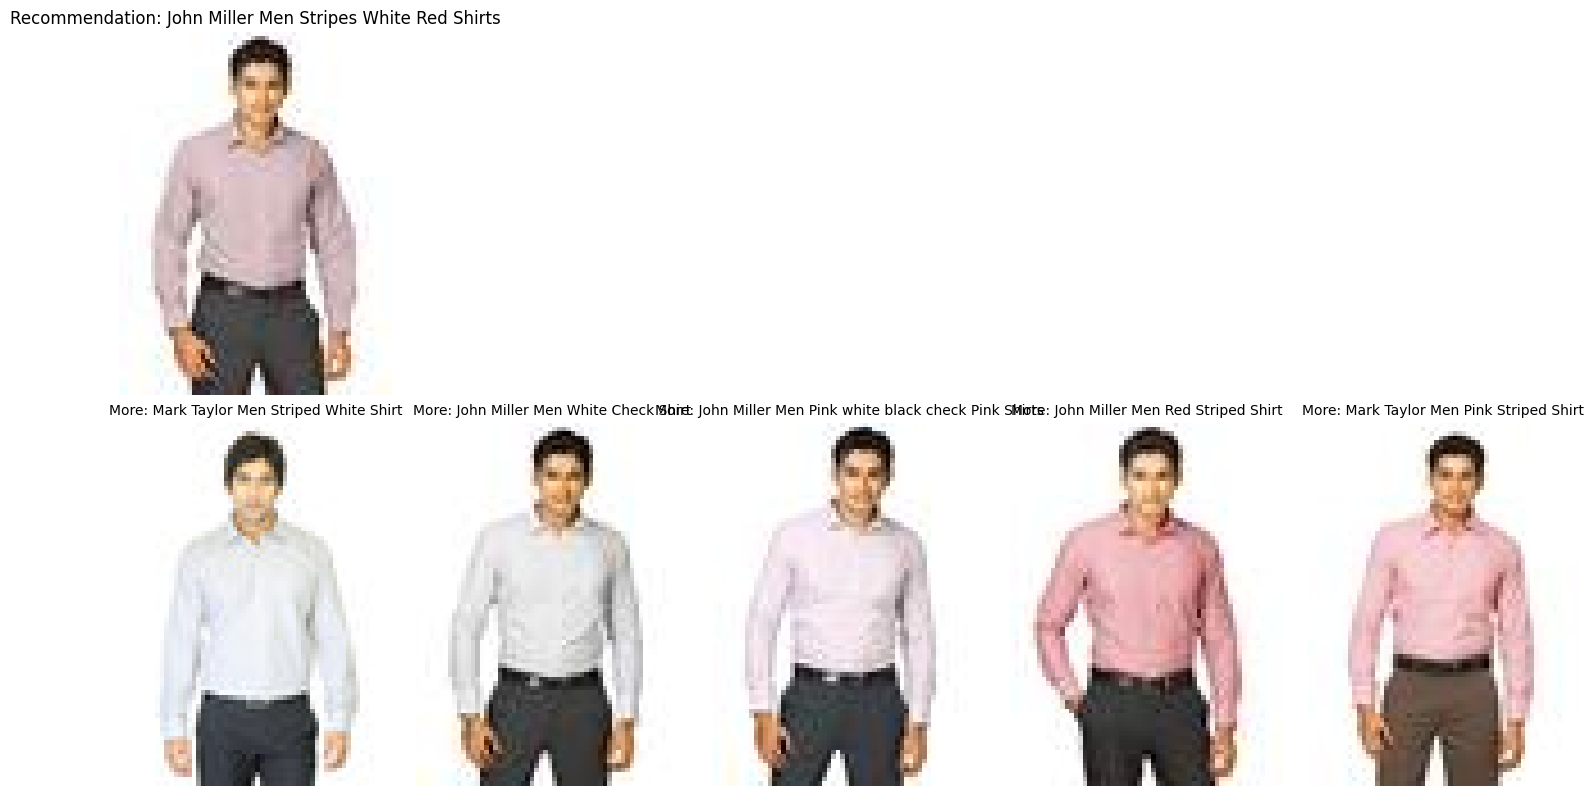

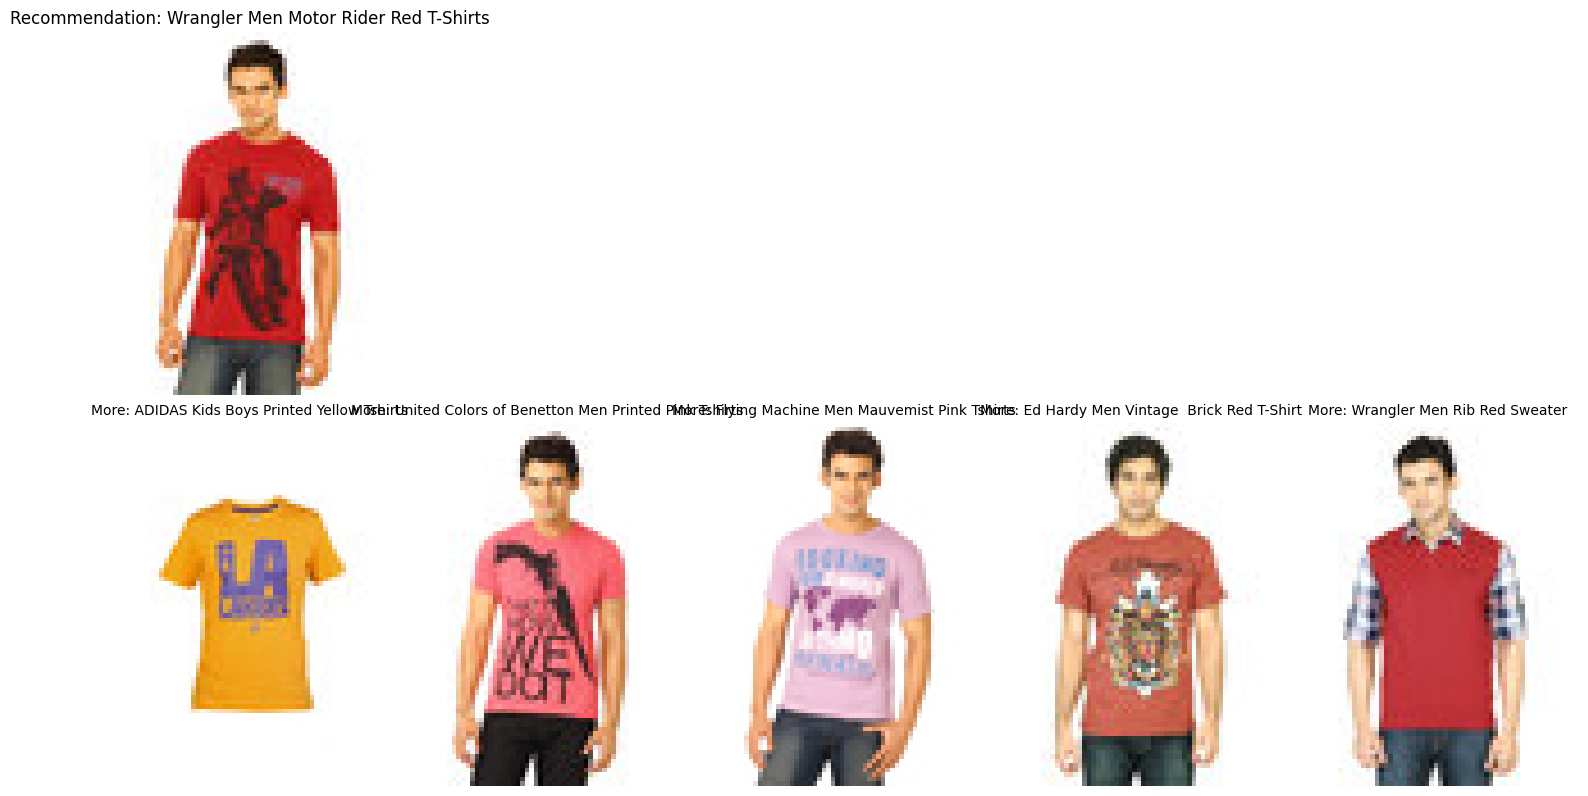

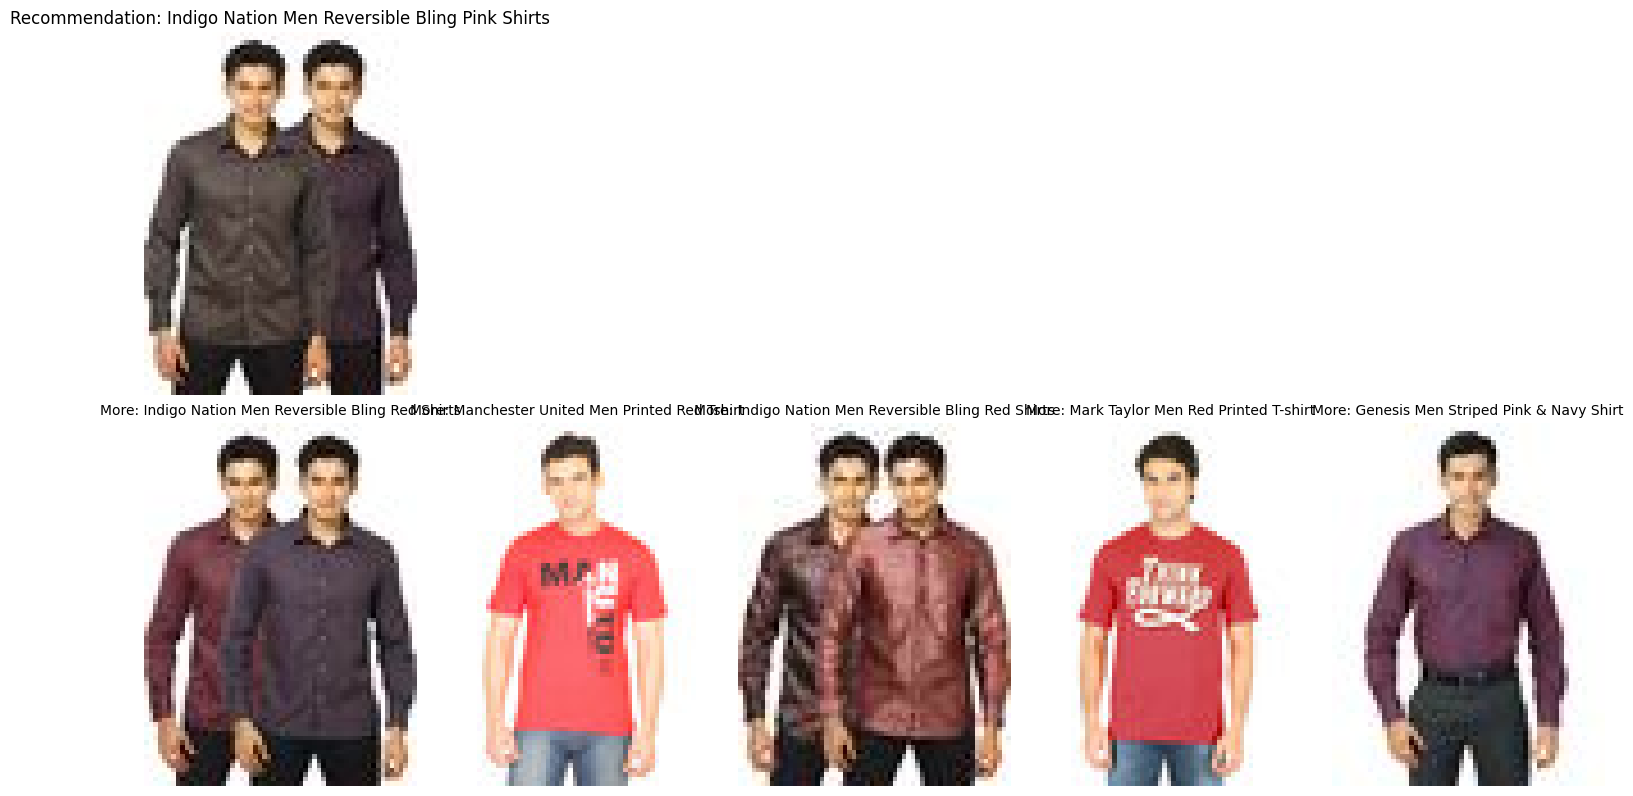

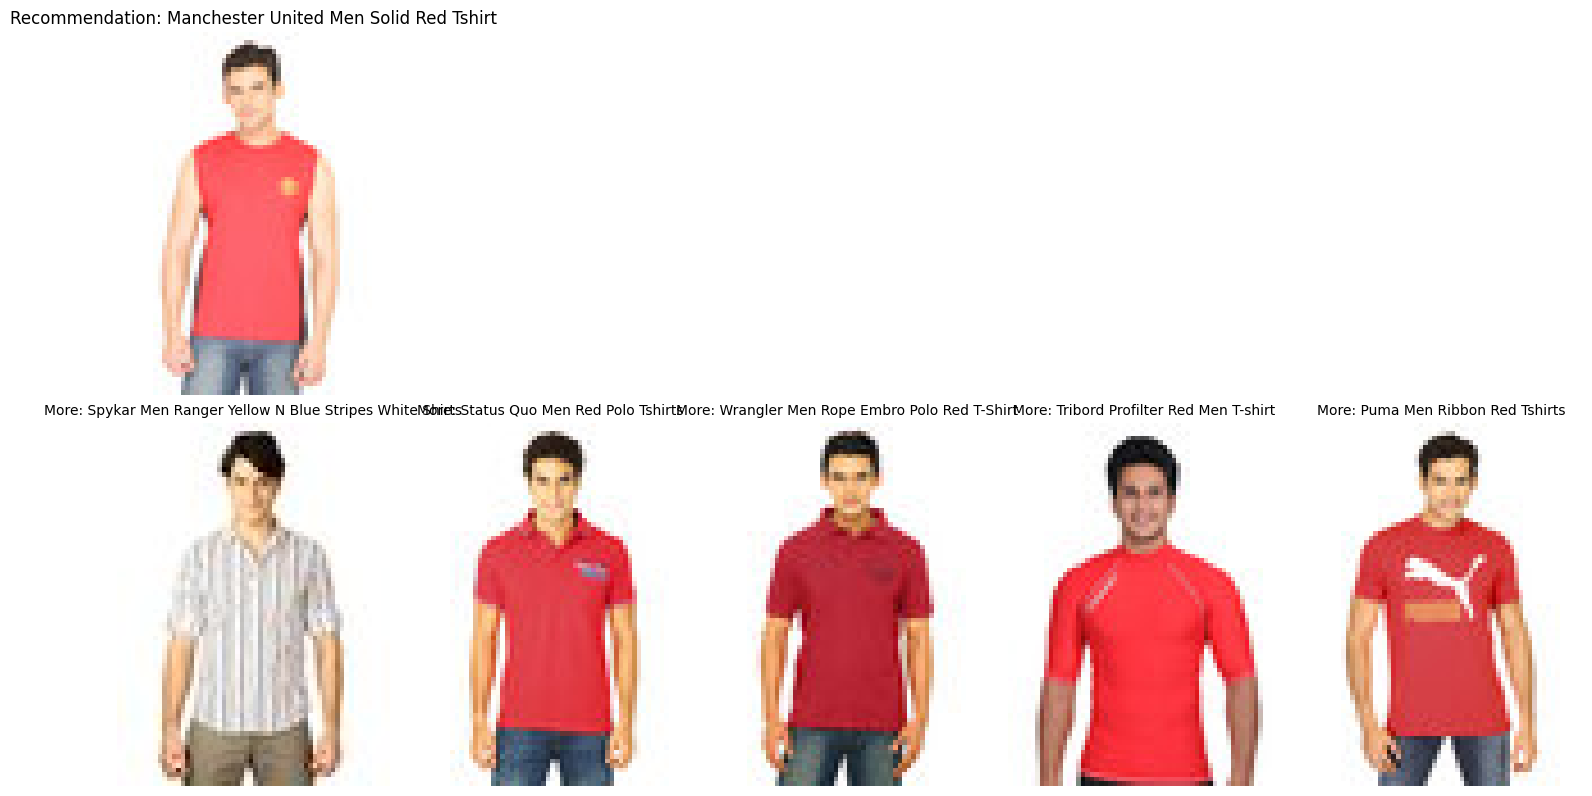

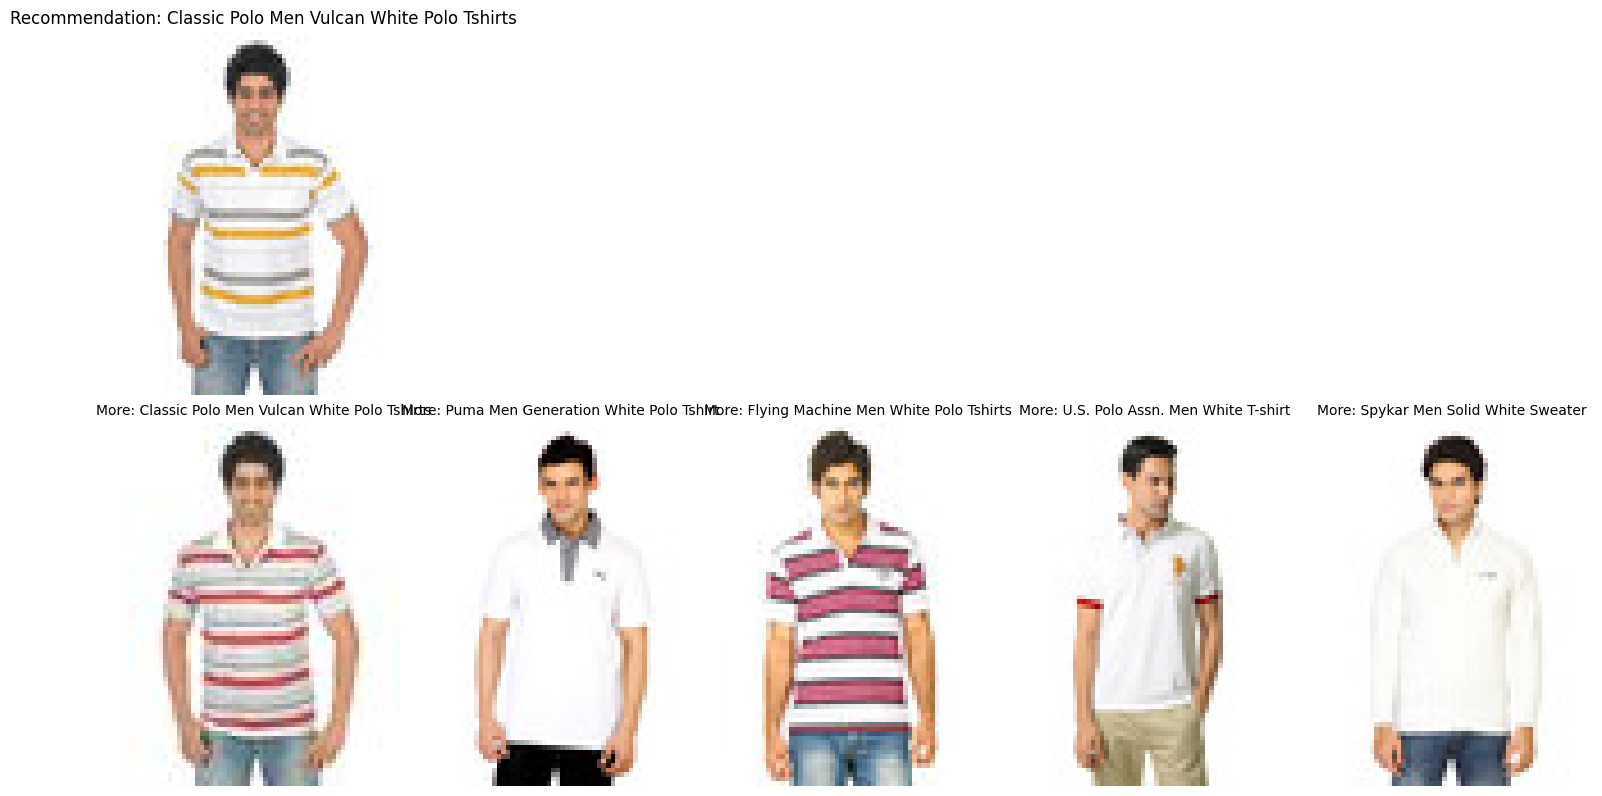

Master Category: Bottomwear


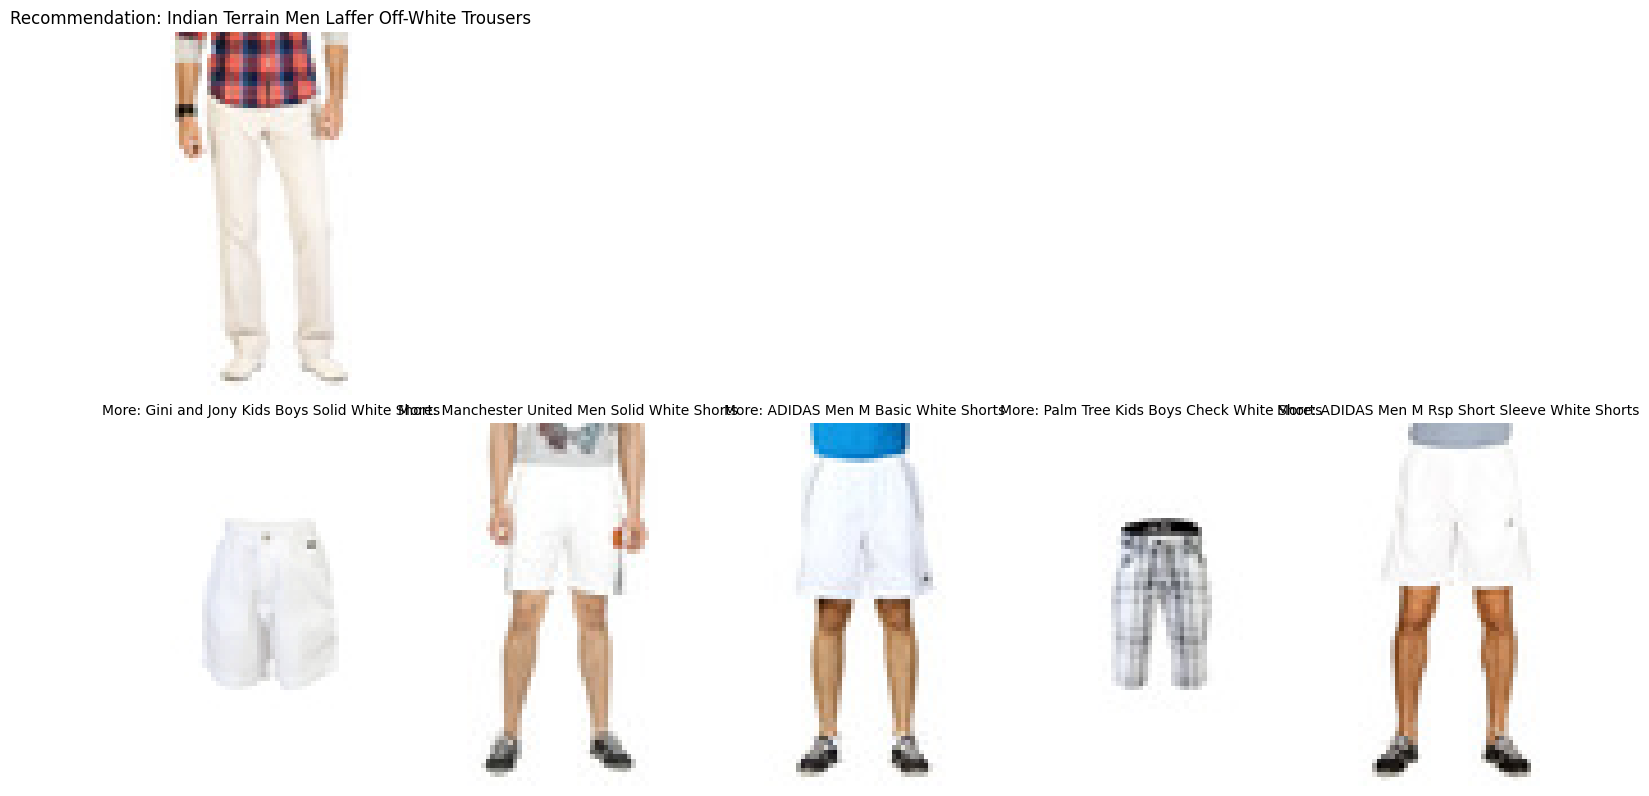

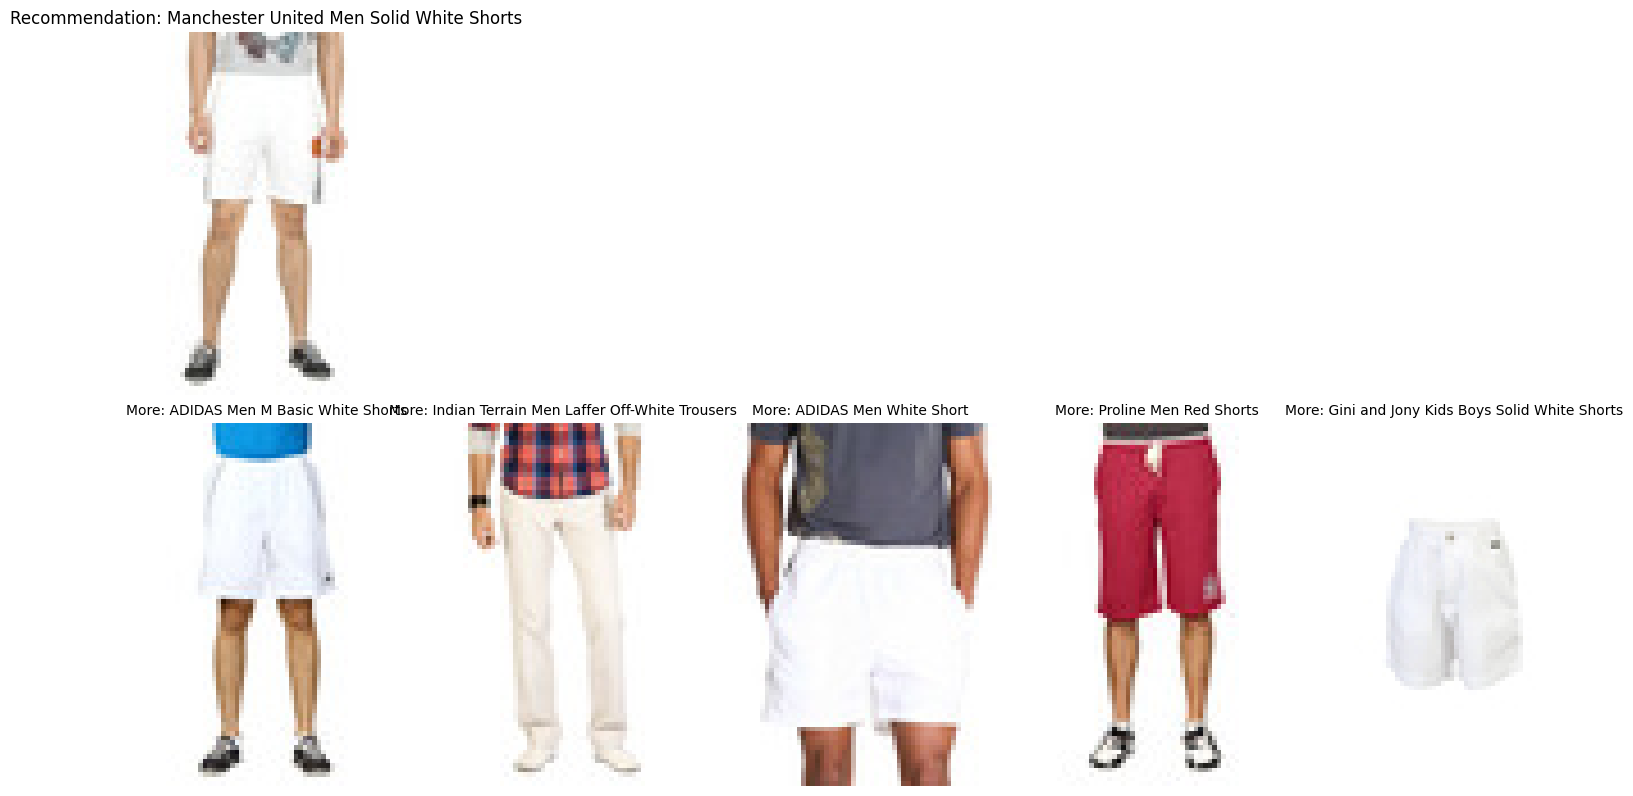

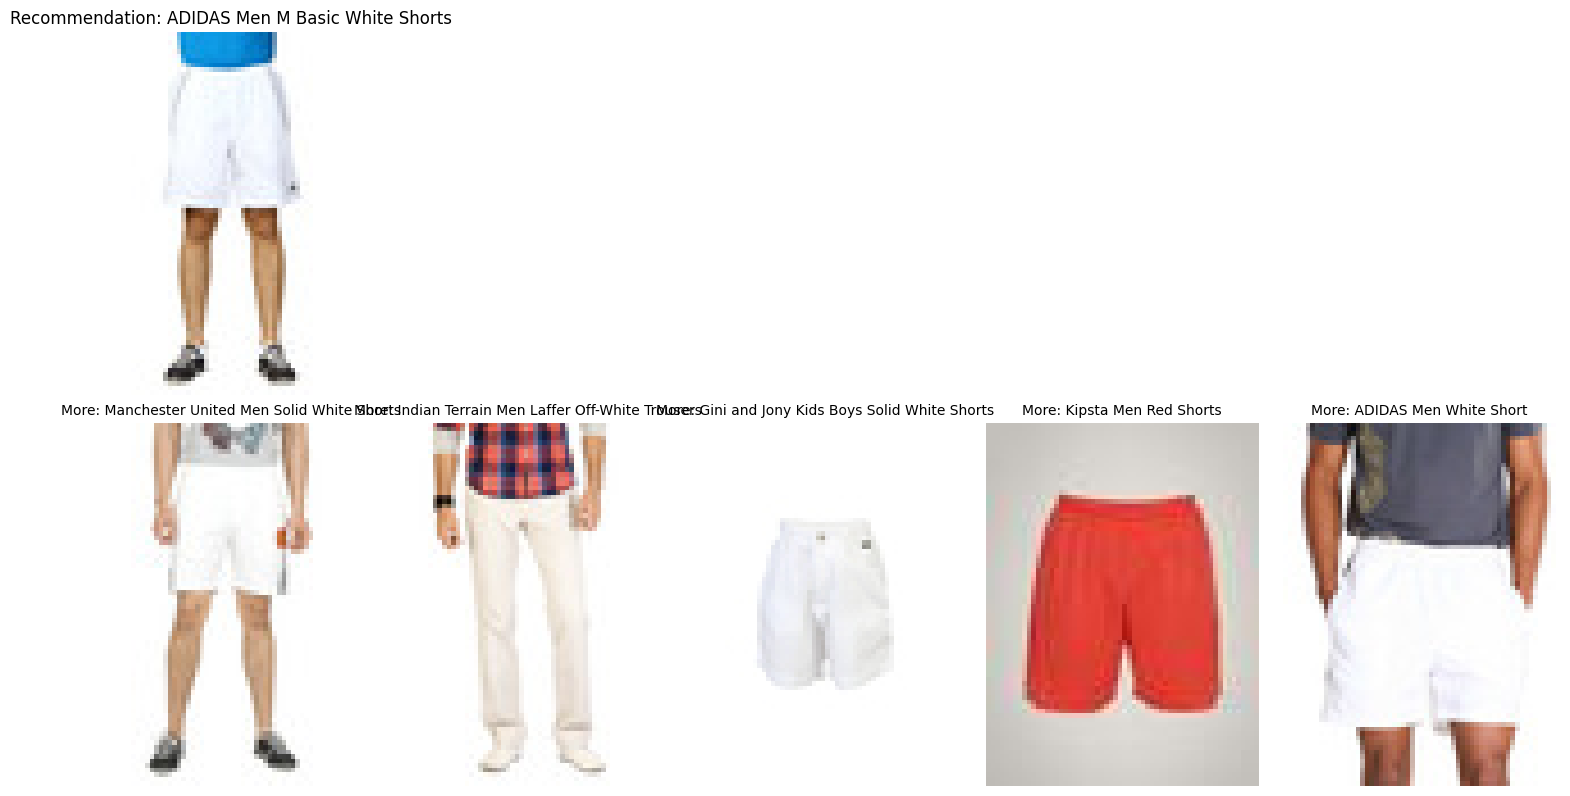

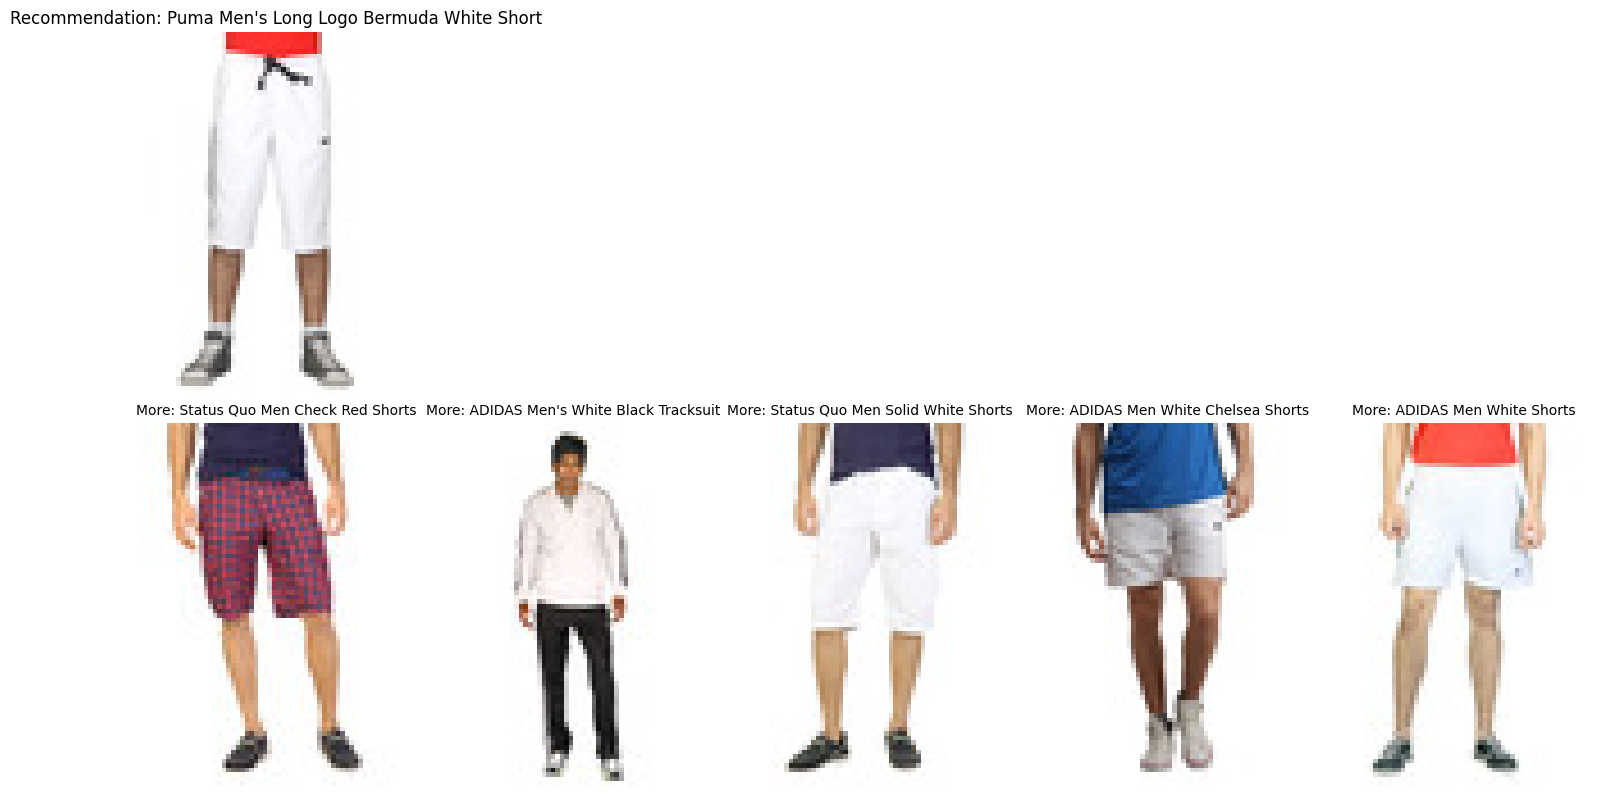

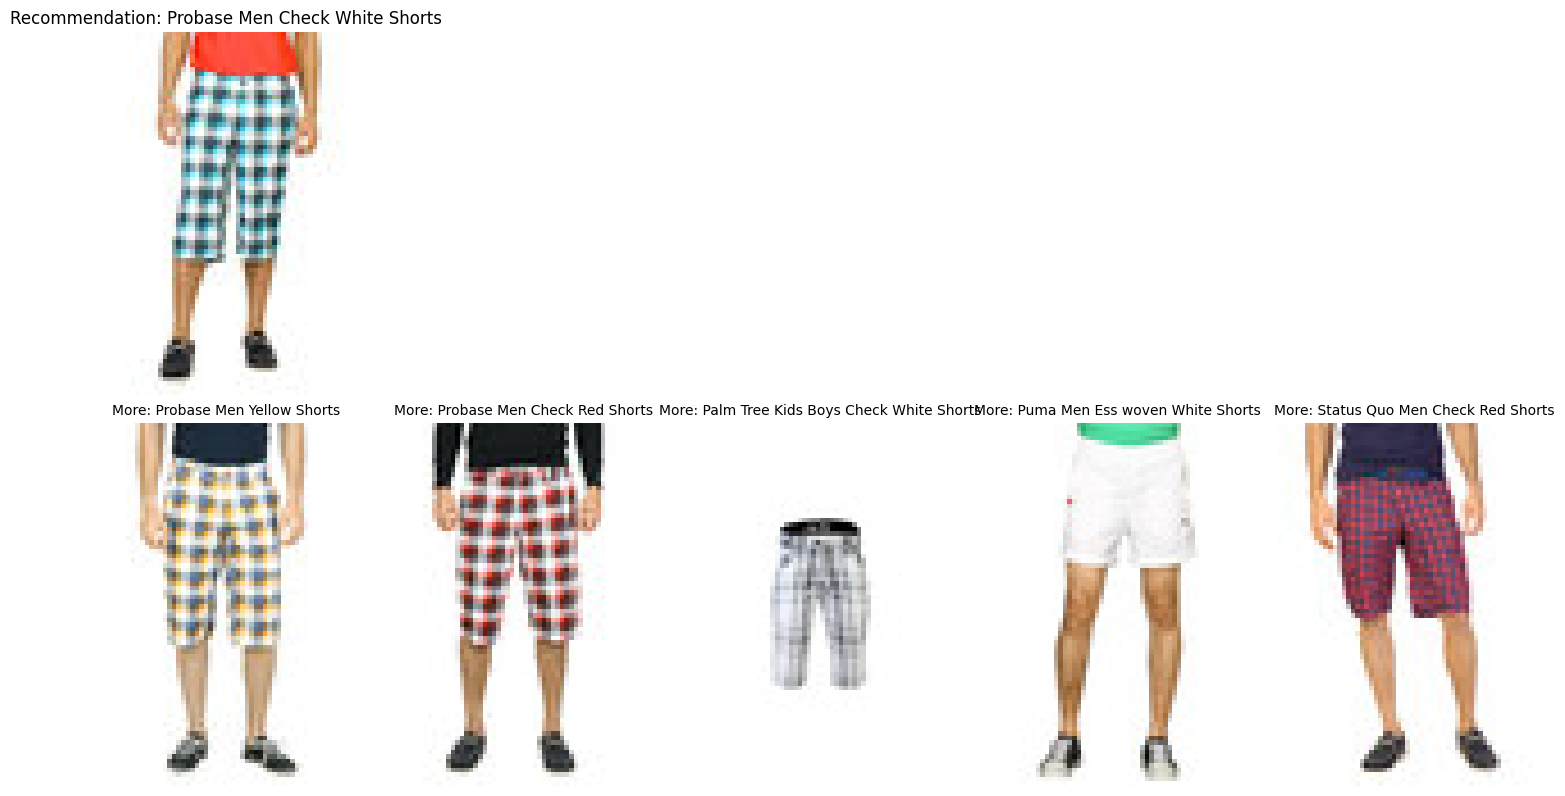

Master Category: Footwear


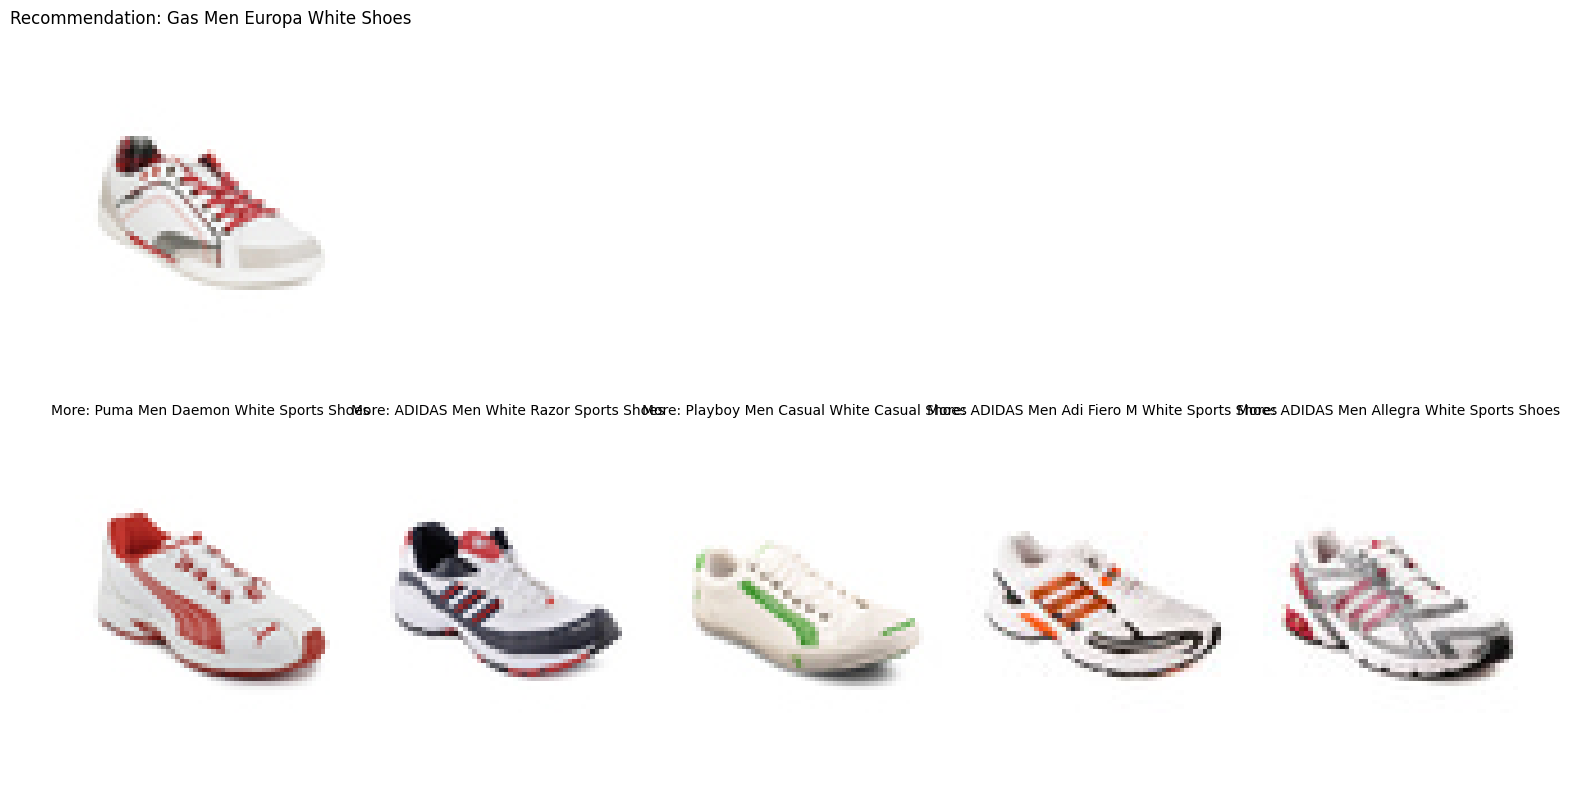

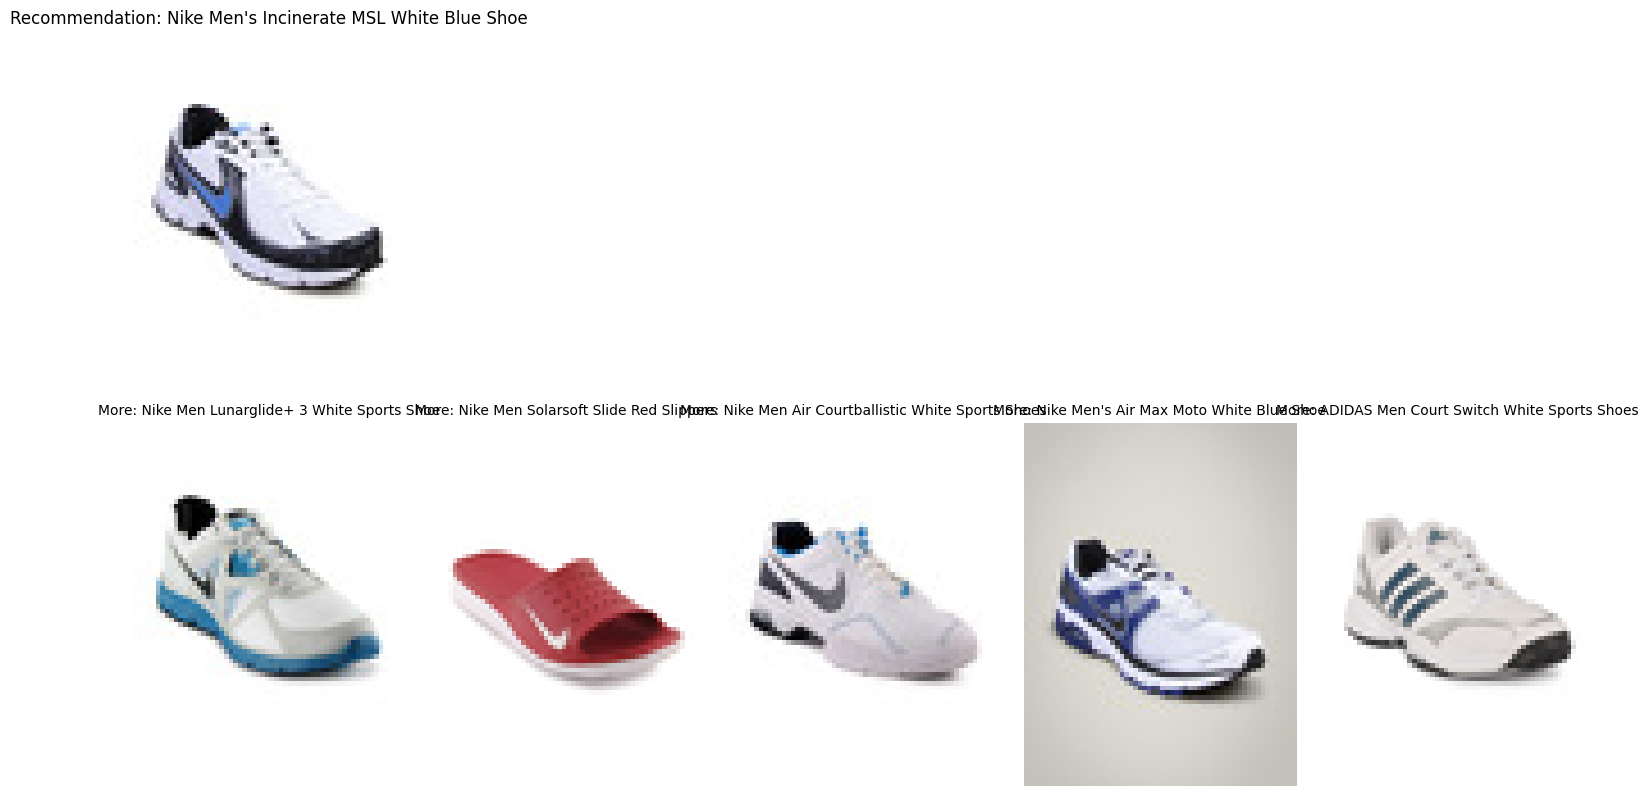

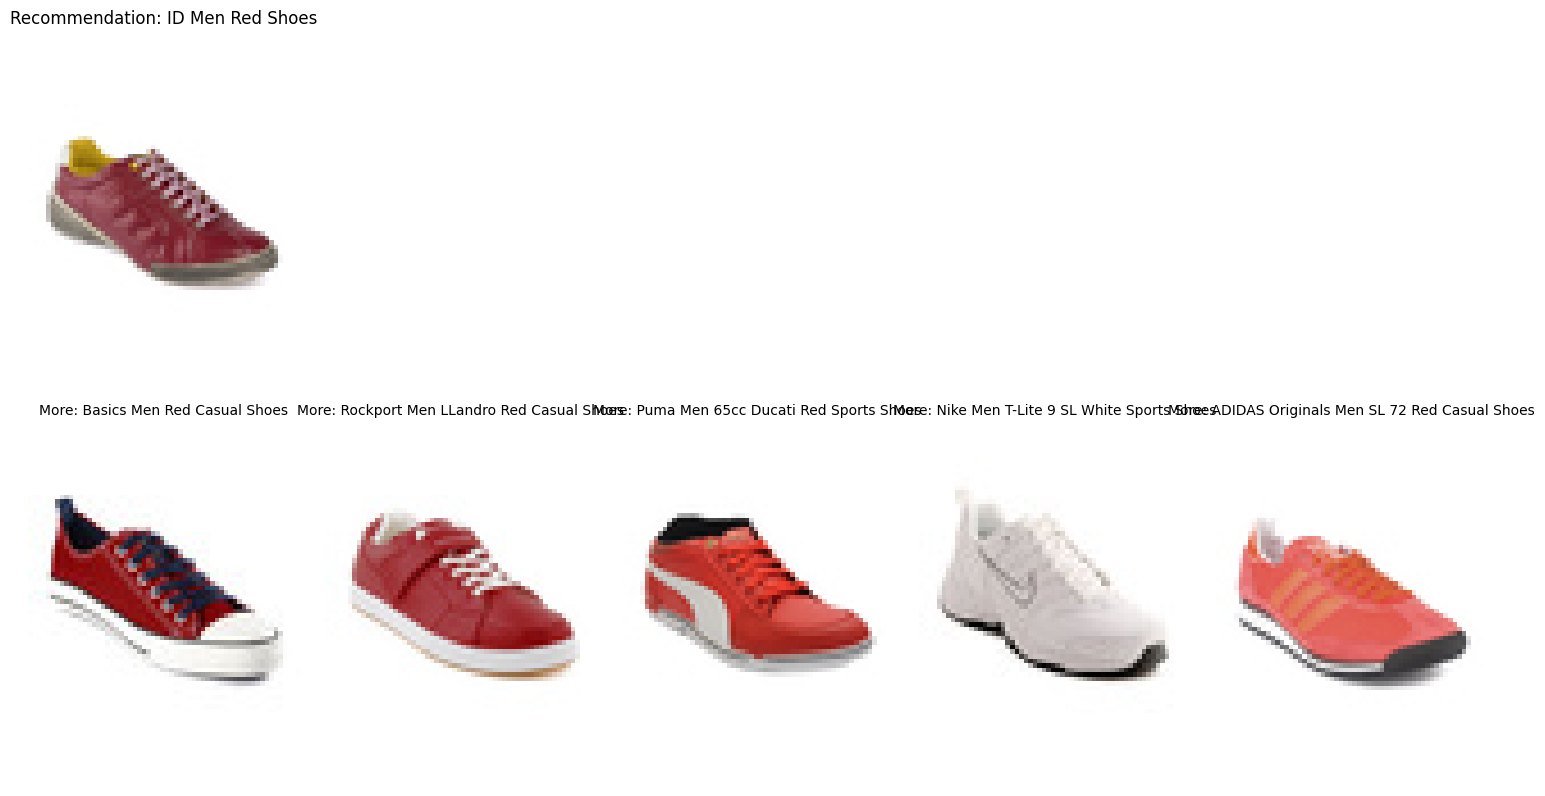

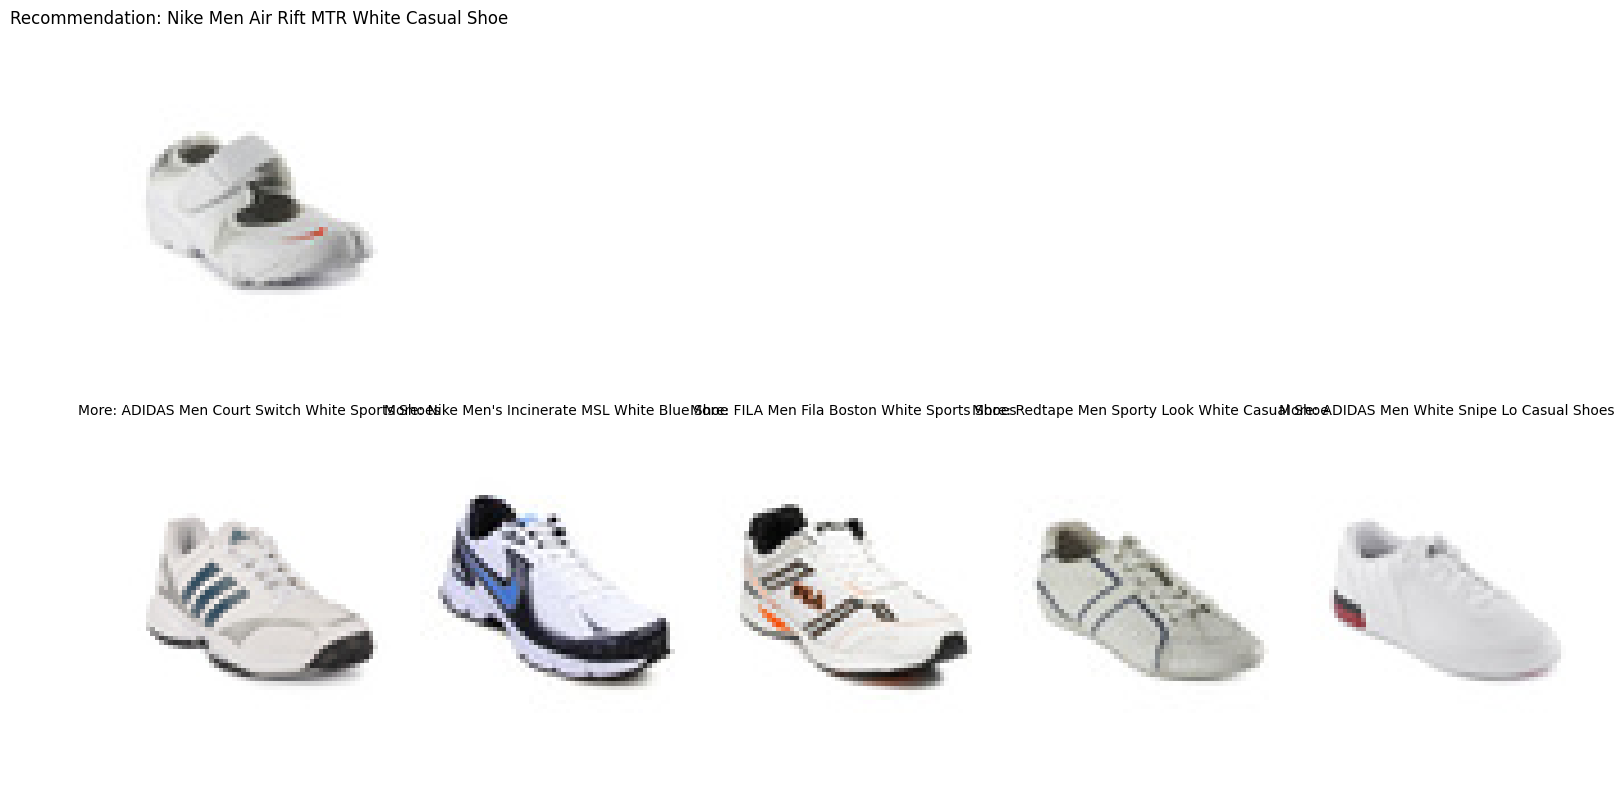

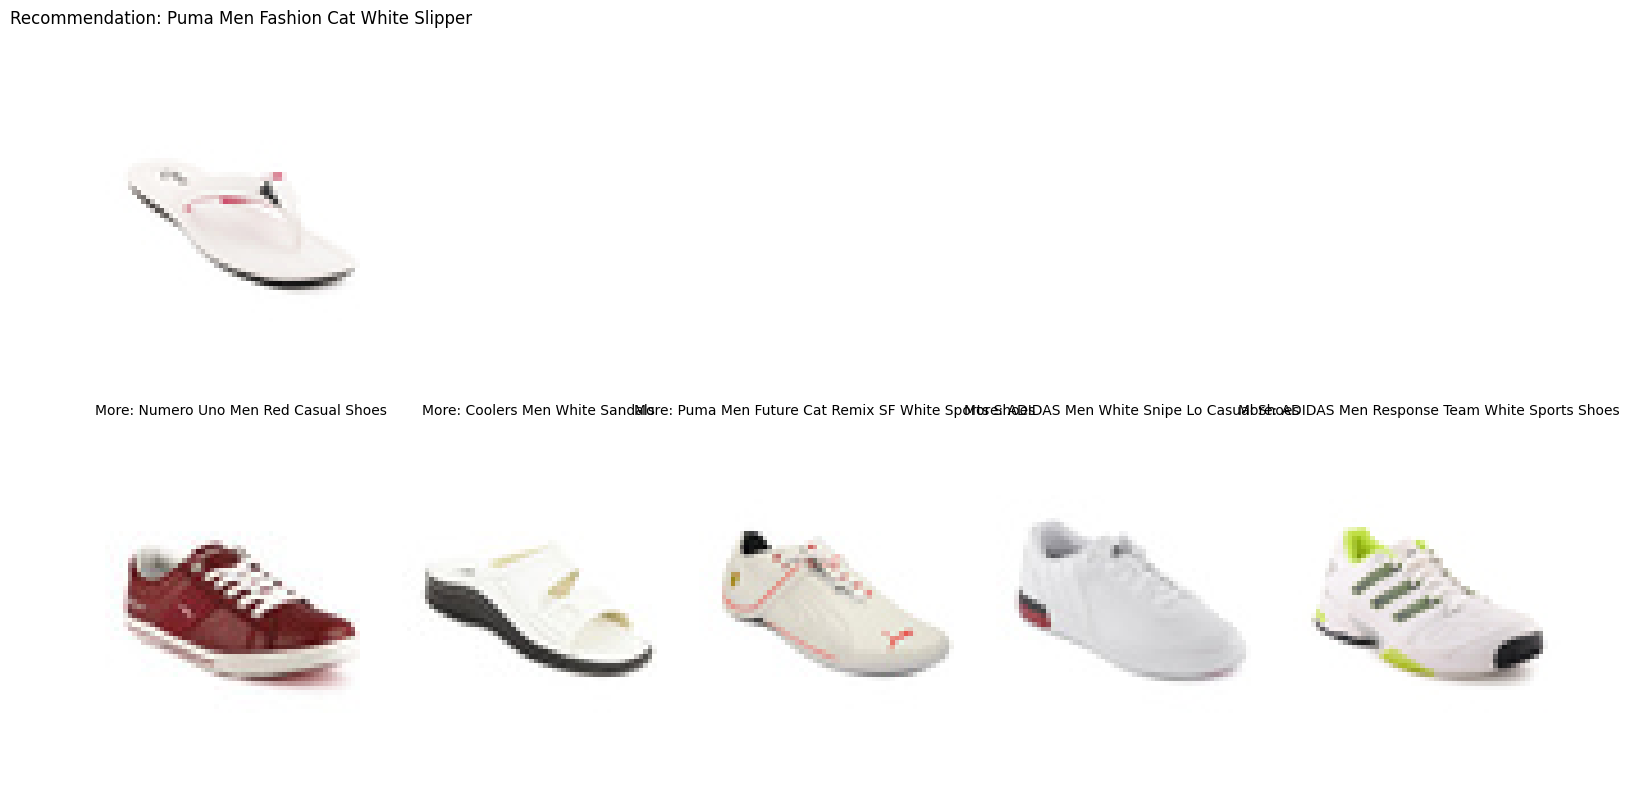

In [24]:
def show_recommendations_with_grid(recommendations, image_dir, data):
    for master_category, items in recommendations.items():
        print(f"Master Category: {master_category}")
        if isinstance(items, str):
            # If no items were found for this category
            print(items)
            continue
        
        for rec in items:
            input_image = rec['input_item']
            recommended_images = rec['recommended_items']
            
            # Get productDisplayName for the input image
            input_display_name = data[data['image'] == input_image]['productDisplayName'].values[0]
            
            # Prepare the figure
            num_recommendations = len(recommended_images)
            fig, axes = plt.subplots(2, max(num_recommendations, 1), figsize=(15, 8))
            
            # Show the main recommended image (Recommendation)
            input_image_path = os.path.join(image_dir, input_image)
            img = Image.open(input_image_path)
            axes[0, 0].imshow(img)
            axes[0, 0].axis('off')
            axes[0, 0].set_title(f"Recommendation: {input_display_name}", fontsize=12)
            
            # Hide unused axes in the top row
            for ax in axes[0, 1:]:
                ax.axis('off')
            
            # Show more recommendations in the second row
            for i, recommended_image in enumerate(recommended_images):
                recommended_image_path = os.path.join(image_dir, recommended_image)
                recommended_display_name = data[data['image'] == recommended_image]['productDisplayName'].values[0]
                img = Image.open(recommended_image_path)
                axes[1, i].imshow(img)
                axes[1, i].axis('off')
                axes[1, i].set_title(f"More: {recommended_display_name}", fontsize=10)
            
            # Hide any unused axes in the second row
            for ax in axes[1, len(recommended_images):]:
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()

# Example usage
show_recommendations_with_grid(recommendations_by_category, image_directory, data)
